In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("monthly_milk_production.csv",index_col="Date",parse_dates=True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

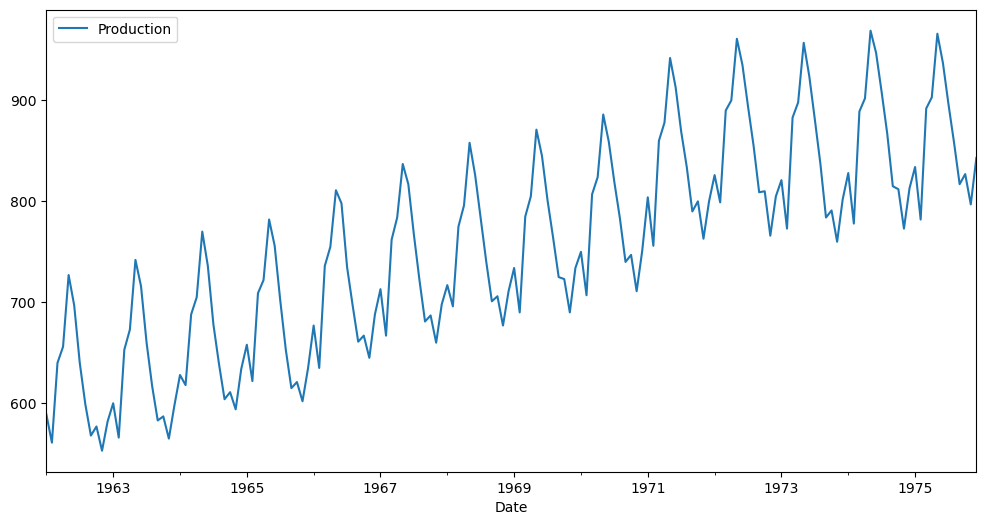

In [3]:
df.plot(figsize=(12,6))

In [4]:
#!pip install statsmodels

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
df.index.freq="MS"

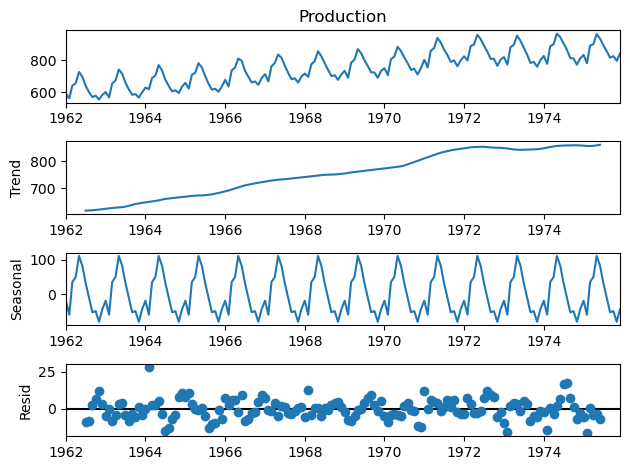

In [7]:
result = seasonal_decompose(df["Production"])
result.plot();

In [8]:
len(df)

168

In [9]:
train = df.iloc[:156]
test = df.iloc[156:]

In [10]:
train.shape

(156, 1)

In [11]:
train.iloc[0], train.iloc[-1]

(Production    589
 Name: 1962-01-01 00:00:00, dtype: int64,
 Production    813
 Name: 1974-12-01 00:00:00, dtype: int64)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()

In [13]:
scalar.fit(train)
scaled_train = scalar.transform(train)
scaled_test = scalar.transform(test)

In [14]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
n_input = 3
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
len(scaled_train), len(generator)

(156, 153)

In [18]:
X, y = generator[0]
print("Input:",X.ravel())
print("Output:",y)

Input: [0.08653846 0.01923077 0.20913462]
Output: [[0.24759615]]


In [19]:
X.shape

(1, 3, 1)

In [20]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
generator[0][0].shape

(1, 12, 1)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM 

In [23]:
model = Sequential()
model.add(LSTM(1000,activation="relu",input_shape=(12,1)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 4009001 (15.29 MB)
Trainable params: 4009001 (15.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.fit(generator,epochs=30)

Epoch 1/30

144/144 [==============================] - 30s 193ms/step - loss: 0.0428
Epoch 2/30
144/144 [==============================] - 28s 193ms/step - loss: 0.0301
Epoch 3/30
144/144 [==============================] - 29s 200ms/step - loss: 0.0114
Epoch 4/30
144/144 [==============================] - 27s 186ms/step - loss: 0.0061
Epoch 5/30
144/144 [==============================] - 27s 184ms/step - loss: 0.0034
Epoch 6/30
144/144 [==============================] - 27s 188ms/step - loss: 0.0023
Epoch 7/30
144/144 [==============================] - 28s 193ms/step - loss: 0.0038
Epoch 8/30
144/144 [==============================] - 30s 207ms/step - loss: 0.0033
Epoch 9/30
144/144 [==============================] - 39s 271ms/step - loss: 0.0032
Epoch 10/30
144/144 [==============================] - 37s 258ms/step - loss: 0.0027
Epoch 11/30
144/144 [==============================] - 30s 208ms/step - loss: 0.0029
Epoch 12/30
144/144 [==============================] - 35s 245ms/step - l

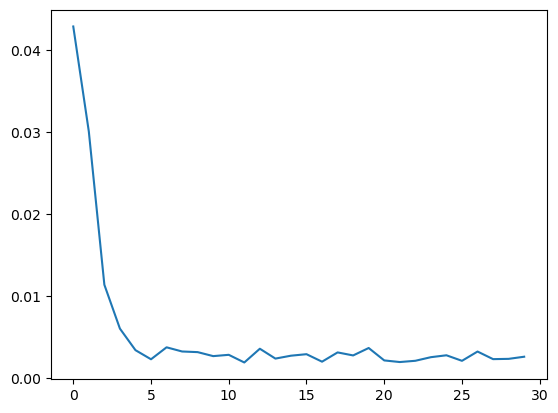

In [26]:
loss = model.history.history["loss"]
plt.plot(range(len(loss)),loss)

In [27]:
last_train_batch = scaled_train[-12:]

In [34]:
last_train_batch = last_train_batch.reshape((1,12,1))

In [35]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 48ms/step


array([[0.6690513]], dtype=float32)

In [36]:
scaled_test[0]

array([0.67548077])

In [37]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, 12, 1))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 41ms/step


In [38]:
test_predictions

[array([0.6690513], dtype=float32),
 array([0.58766353], dtype=float32),
 array([0.79831153], dtype=float32),
 array([0.8542409], dtype=float32),
 array([0.98009074], dtype=float32),
 array([0.95209813], dtype=float32),
 array([0.86665803], dtype=float32),
 array([0.773273], dtype=float32),
 array([0.6599823], dtype=float32),
 array([0.63686293], dtype=float32),
 array([0.5635328], dtype=float32),
 array([0.6334407], dtype=float32)]

In [39]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [41]:
true_predictions = scalar.inverse_transform(test_predictions)

In [42]:
test['Predictions'] = true_predictions

C:\Users\hp\AppData\Local\Temp\ipykernel_14060\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

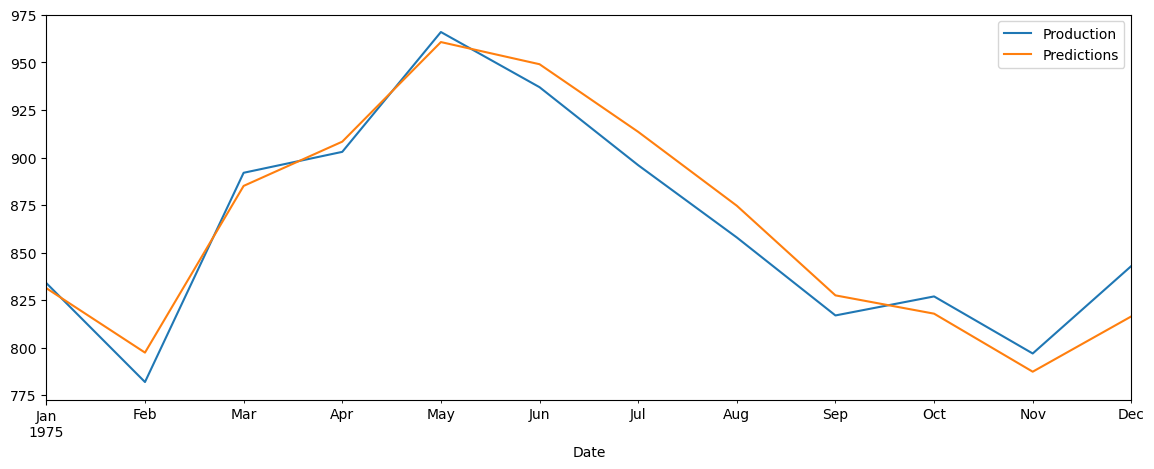

In [43]:
test.plot(figsize=(14,5))

In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

13.13020660149088
